In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType

In [2]:
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tslearn.metrics import cdist_normalized_cc

/home2/s153445/.conda/envs/thesis/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[9]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .getOrCreate()

In [4]:
schema = StructType([
    StructField("bigram", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("count", IntegerType(), True),
    StructField("bigram_percent", FloatType(), True),
    StructField("bigram_percent_smooth", FloatType(), True)])

In [5]:
df = spark.read.option('header', False).schema(schema)\
                     .csv('/data/shared1/cleandata/clean_allfiles')

In [6]:
df = df.drop('bigram_percent_smooth')

### ntile based on median over 40 years

In [7]:
# get dataframe with 40 years betweeen 1920 and 1960
df_prev = df.where((df.year > 1920) & (df.year <= 1960))

In [8]:
# calculate the MEDIAN and variance over bigram percentage
df_prev = df_prev.groupBy('bigram').agg(collect_list('bigram_percent').alias('observations'))

median_udf = udf(lambda x: float(np.median(x)), FloatType())
var_udf = udf(lambda x: float(np.var(x)), FloatType())

df_prev = df_prev.withColumn("medianA", median_udf("observations"))
df_prev = df_prev.withColumn("variance", var_udf("observations"))

### Histogram showing the distribution of the variance in the 40 years

In [9]:
var_his = df_prev.select('bigram','variance').toPandas()

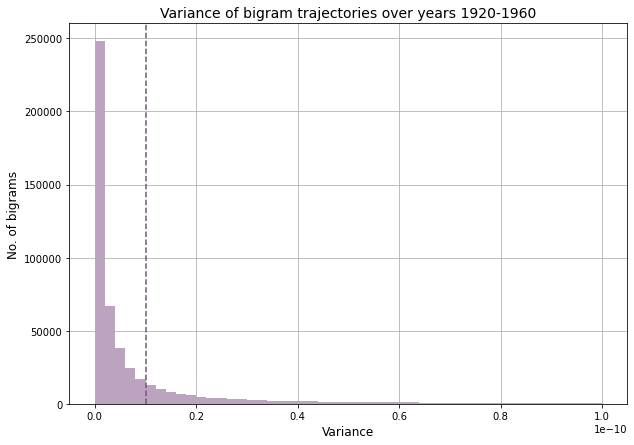

In [256]:
var_his.hist(range=[0,1e-10],bins=50,figsize=(10,7), color='#BCA4C0')
plt.axvline(0.1e-10, linestyle='--', color='#6F5873')
plt.xlabel('Variance', fontsize=12)
plt.ylabel('No. of bigrams', fontsize=12)
plt.title('Variance of bigram trajectories over years 1920-1960',fontsize=14)
plt.savefig('variance_distribution')
plt.show()

### Make ntiles

In [10]:
# choose the bigrams with the lowest variance in their observations
#df_prev.where(col('variance') > 0.1e-7).count()
df_prev = df_prev.where(col('variance') < 0.1e-10)

In [11]:
# make a dataframe with all the bigrams with 0 median in the 40 years between 1920-1960
df_zero = df_prev.where(col('medianA') == 0)

# take the bigrams with 0 median out
df_prev = df_prev.where(col('medianA') != 0)

In [12]:
# Split the bigrams in 29 ntiles based on the median
w = Window.orderBy("medianA")
df_prev = df_prev.withColumn("ntileA", ntile(29).over(w)) 
df_prev = df_prev.withColumn("ntileA", col('ntileA')+1)

In [13]:
# join the chosen ntiles to the full dataframe with all the years
df_full = df.join(df_prev.select('bigram','medianA','ntileA'), ['bigram'], how='inner') # for all ntiles

In [14]:
# dataframe with median zero bigrams
df_full_zero = df.join(df_zero.select('bigram', 'medianA'), ['bigram'], how='inner')
df_full_zero = df_full_zero.withColumn('ntileA', lit(1))

In [15]:
# join the zero dataframe with the other dataframe
df_union = df_full.union(df_full_zero)

In [16]:
# make a dataframe with the recent years from 1980 to 2019
df_recent = df_union.where((df_union.year > 1980) & (df_union.year <= 2019))

In [17]:
# calculate the MEDIAN
df_recent = df_recent.groupBy('bigram','ntileA').agg(collect_list('bigram_percent').alias('observations'))
df_recent = df_recent.withColumn("medianB", median_udf("observations"))

In [18]:
# make 30 new ntiles for each of the chosen ntiles
w = Window.partitionBy('ntileA').orderBy("medianB")
df_recent = df_recent.withColumn("ntileB", ntile(30).over(w)) 

In [19]:
# join the chosen ntiles with the dataframe with all the years
df_full_new = df_union.join(df_recent.select('bigram','medianB','ntileB'), ['bigram'], how='inner')

In [20]:
df_full_new.printSchema()

root
 |-- bigram: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- bigram_percent: float (nullable = true)
 |-- medianA: float (nullable = true)
 |-- ntileA: integer (nullable = true)
 |-- medianB: float (nullable = true)
 |-- ntileB: integer (nullable = true)



### Box plots of medians 

In [21]:
medians = df_full_new.select('bigram','medianA', 'medianB', 'ntileA', 'ntileB').distinct().toPandas()

In [22]:
medians = medians.drop(['bigram'], axis=1)

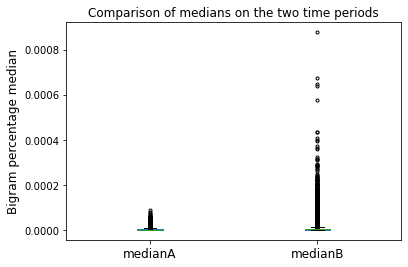

In [23]:
medians[['medianA', 'medianB']].plot.box(figsize=(6,4), sym='.')
plt.title('Comparison of medians on the two time periods', fontsize=12)
plt.ylabel('Bigram percentage median', fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('median_boxplot_outliers_new',bbox_inches = 'tight')
plt.show()

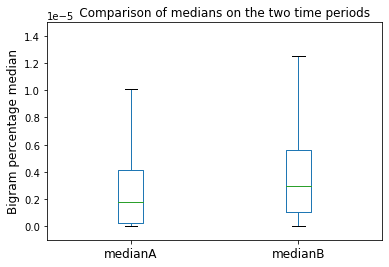

In [24]:
medians[['medianA', 'medianB']].plot.box(figsize=(6,4), ylim=[-1e-6, 1.5e-5], sym='')
plt.title('     Comparison of medians on the two time periods', fontsize=12)
plt.ylabel('Bigram percentage median', fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('median_boxplot_no_outliers_new', bbox_inches = 'tight')
plt.show()

In [25]:
df = pd.DataFrame()
for i in range(1, 31):
    df[i] = pd.DataFrame(medians[(medians.ntileA == i) & (medians.ntileB == 29)]
                         ['medianB'][0:400]).reset_index().medianB  

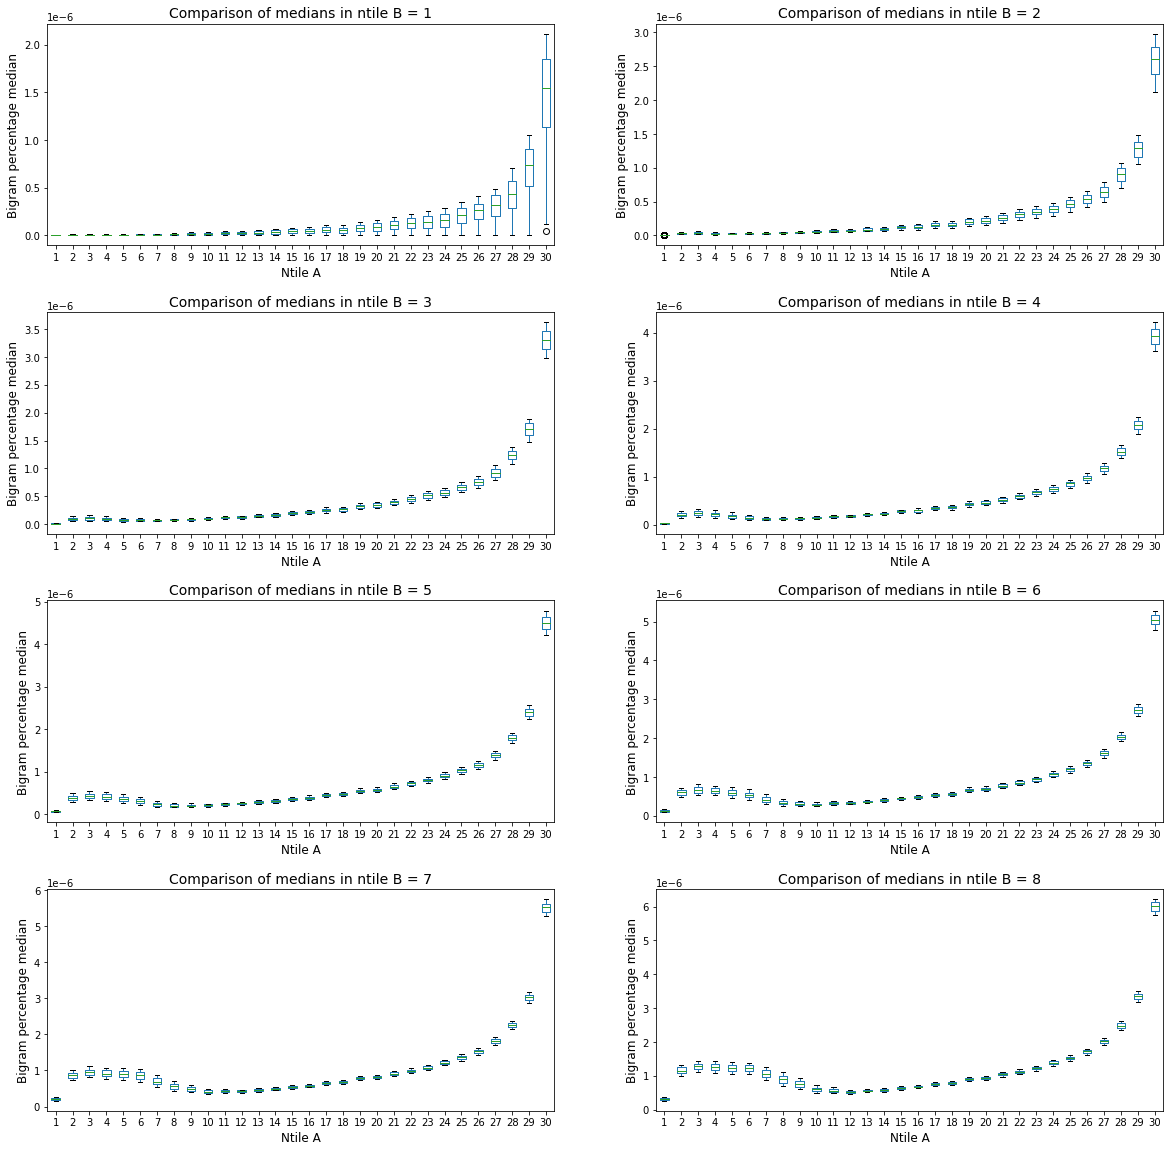

In [36]:
plt.figure(figsize=(20, 20))
for i in range(1, 9):
    df = pd.DataFrame()
    for j in range(1, 31):
        df[j] = pd.DataFrame(medians[(medians.ntileA == j) & (medians.ntileB == i)]
                             ['medianB'][0:400]).reset_index().medianB  
    ax = plt.subplot(4, 2, i)
    df.plot.box(ax = ax)
    plt.xlabel('Ntile A', fontsize=12)
    plt.ylabel('Bigram percentage median', fontsize=12)
    plt.title('Comparison of medians in ntile B = ' + str(i), fontsize=14)
    plt.subplots_adjust(hspace=0.3)
plt.savefig('boxplots1',bbox_inches='tight')
plt.show()

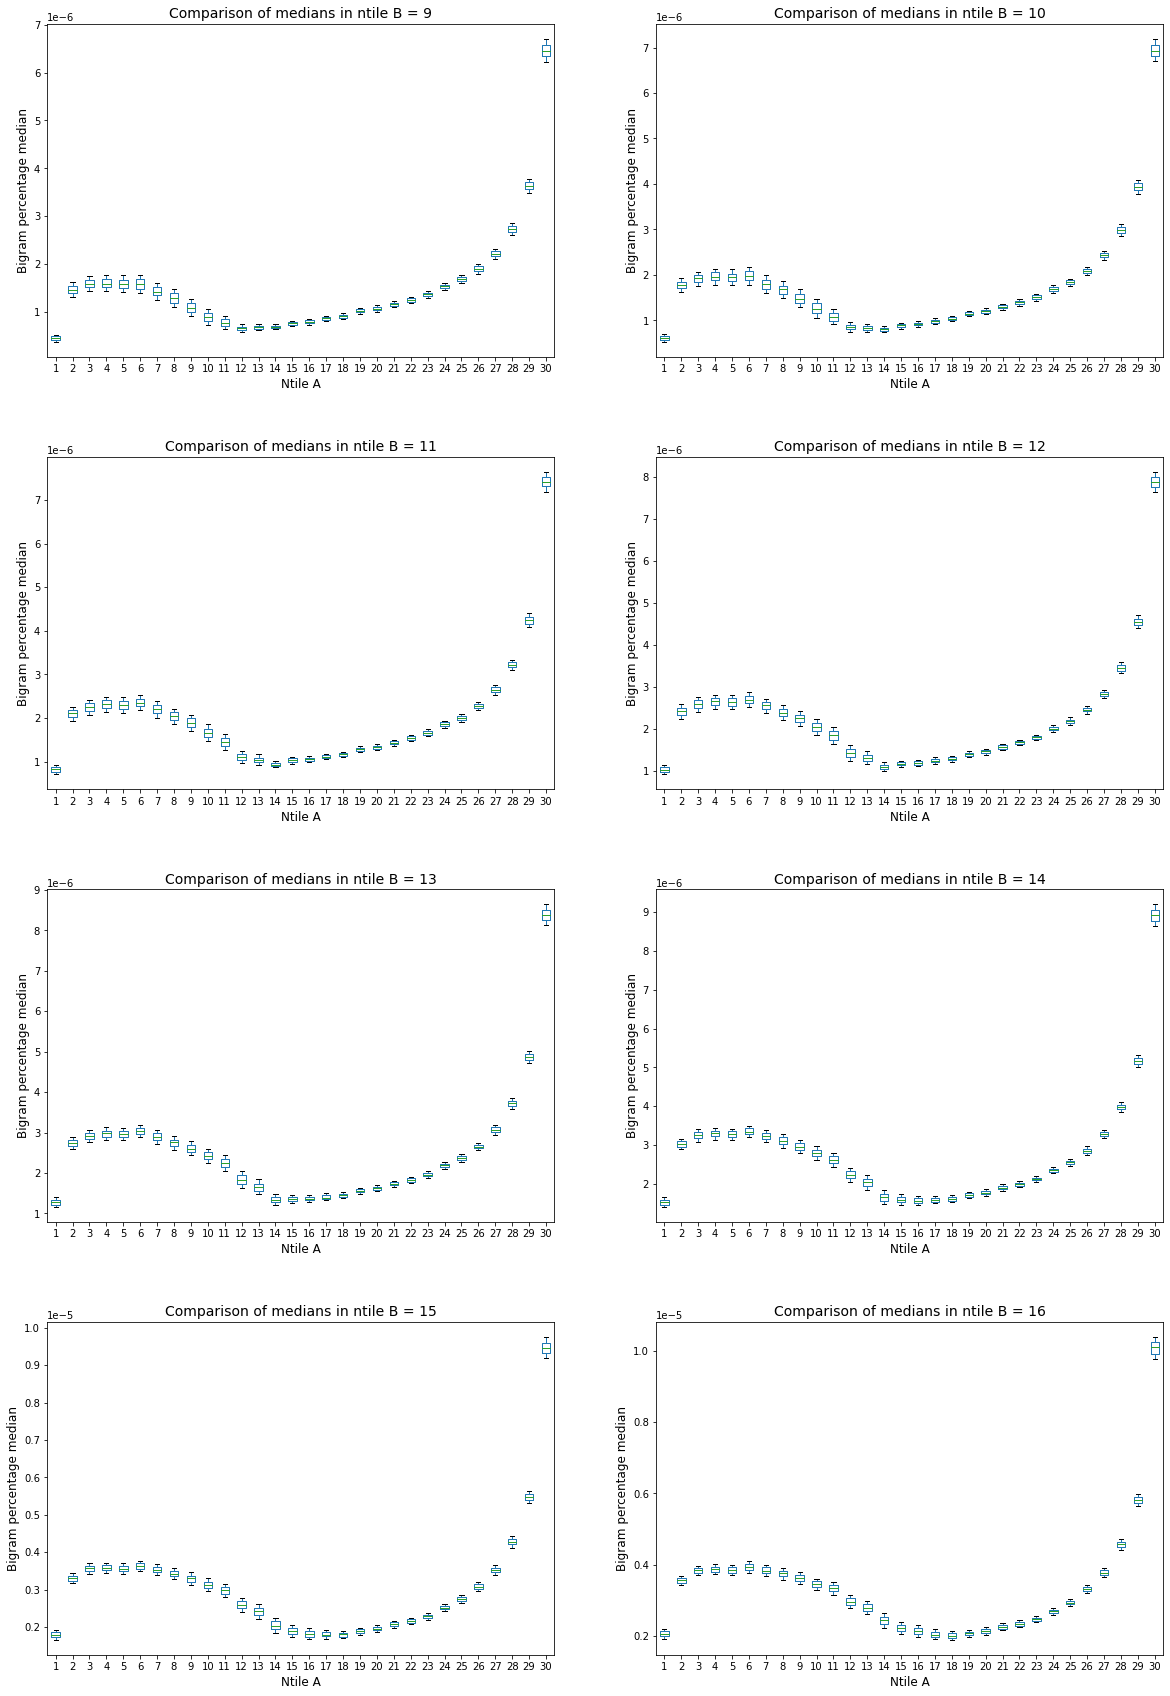

In [30]:
plt.figure(figsize=(20, 30))
for i in range(9, 17):
    df = pd.DataFrame()
    for j in range(1, 31):
        df[j] = pd.DataFrame(medians[(medians.ntileA == j) & (medians.ntileB == i)]
                             ['medianB'][0:400]).reset_index().medianB  
    ax = plt.subplot(4, 2, i-8)
    df.plot.box(ax = ax)
    plt.xlabel('Ntile A', fontsize=12)
    plt.ylabel('Bigram percentage median', fontsize=12)
    plt.title('Comparison of medians in ntile B = ' + str(i), fontsize=14)
    plt.subplots_adjust(hspace=0.3)
plt.savefig('boxplots2',bbox_inches='tight')
plt.show()

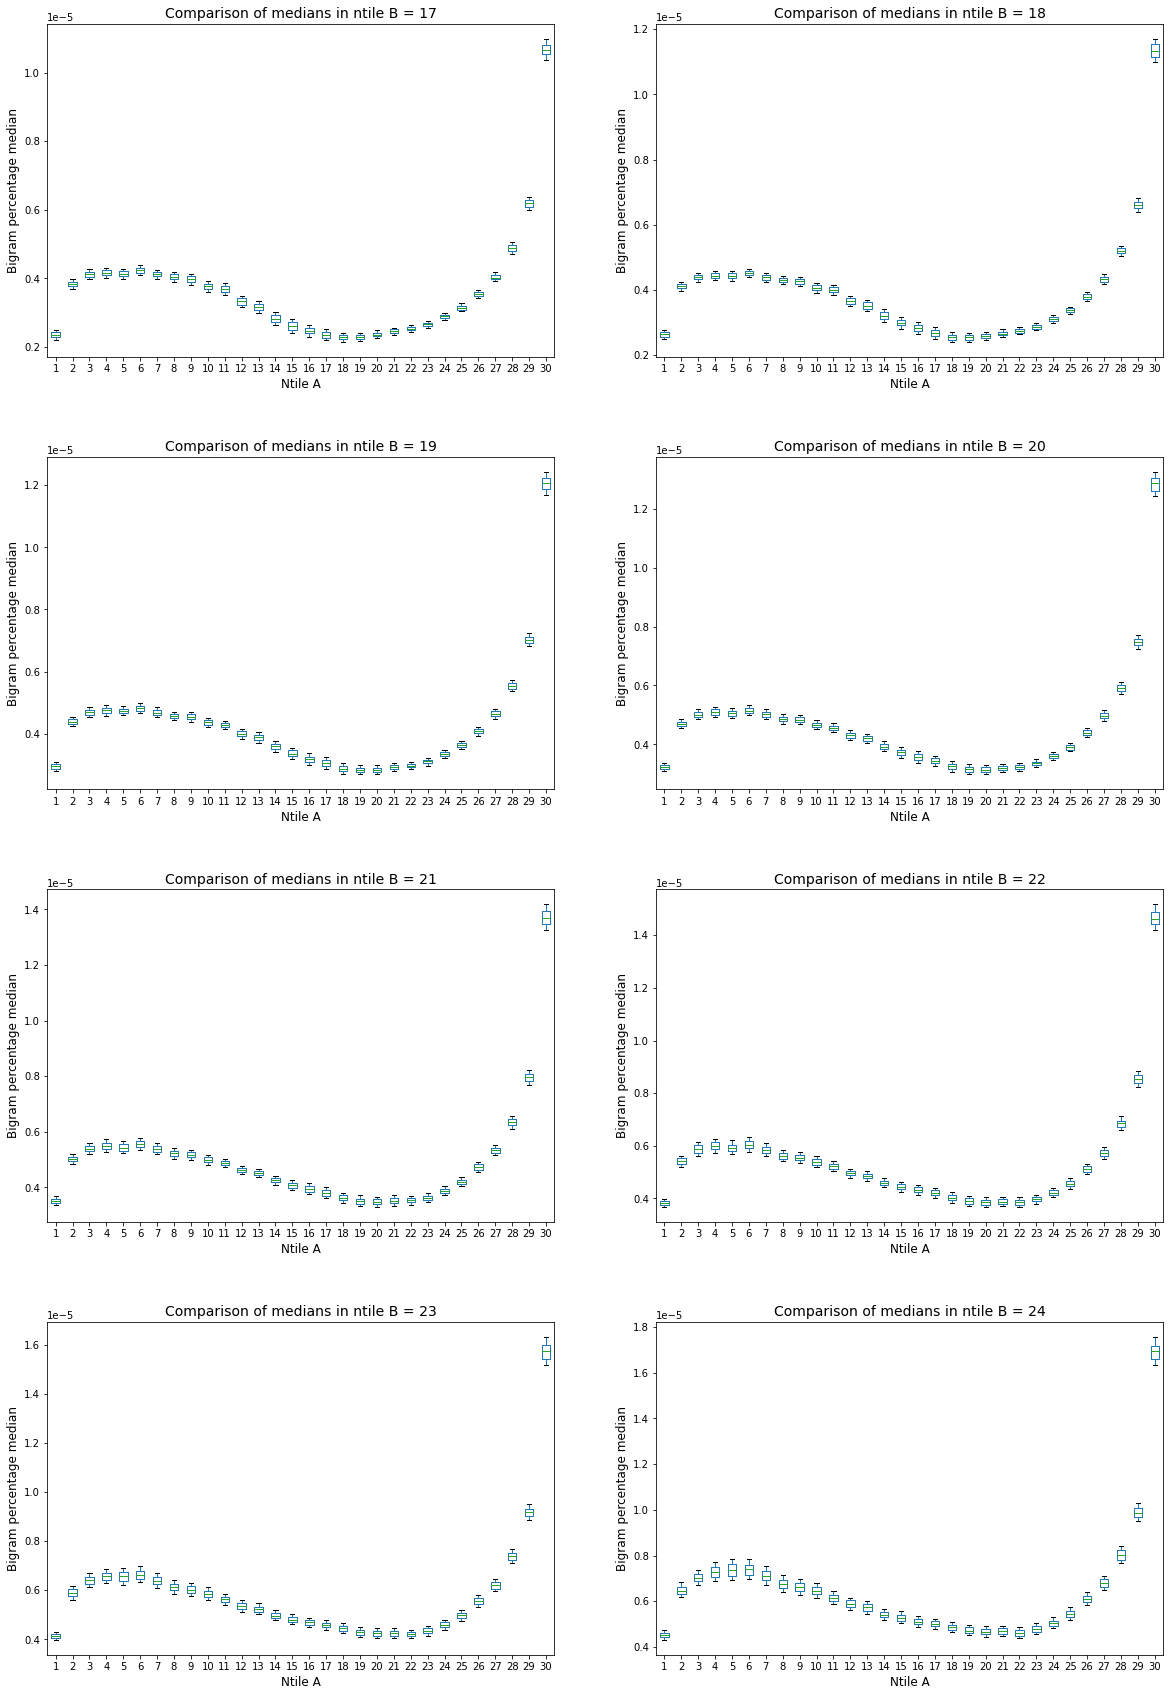

In [31]:
plt.figure(figsize=(20, 30))
for i in range(17, 25):
    df = pd.DataFrame()
    for j in range(1, 31):
        df[j] = pd.DataFrame(medians[(medians.ntileA == j) & (medians.ntileB == i)]
                             ['medianB'][0:400]).reset_index().medianB  
    ax = plt.subplot(4, 2, i-16)
    df.plot.box(ax = ax)
    plt.xlabel('Ntile A', fontsize=12)
    plt.ylabel('Bigram percentage median', fontsize=12)
    plt.title('Comparison of medians in ntile B = ' + str(i), fontsize=14)
    plt.subplots_adjust(hspace=0.3)
plt.savefig('boxplots3',bbox_inches='tight')
plt.show()

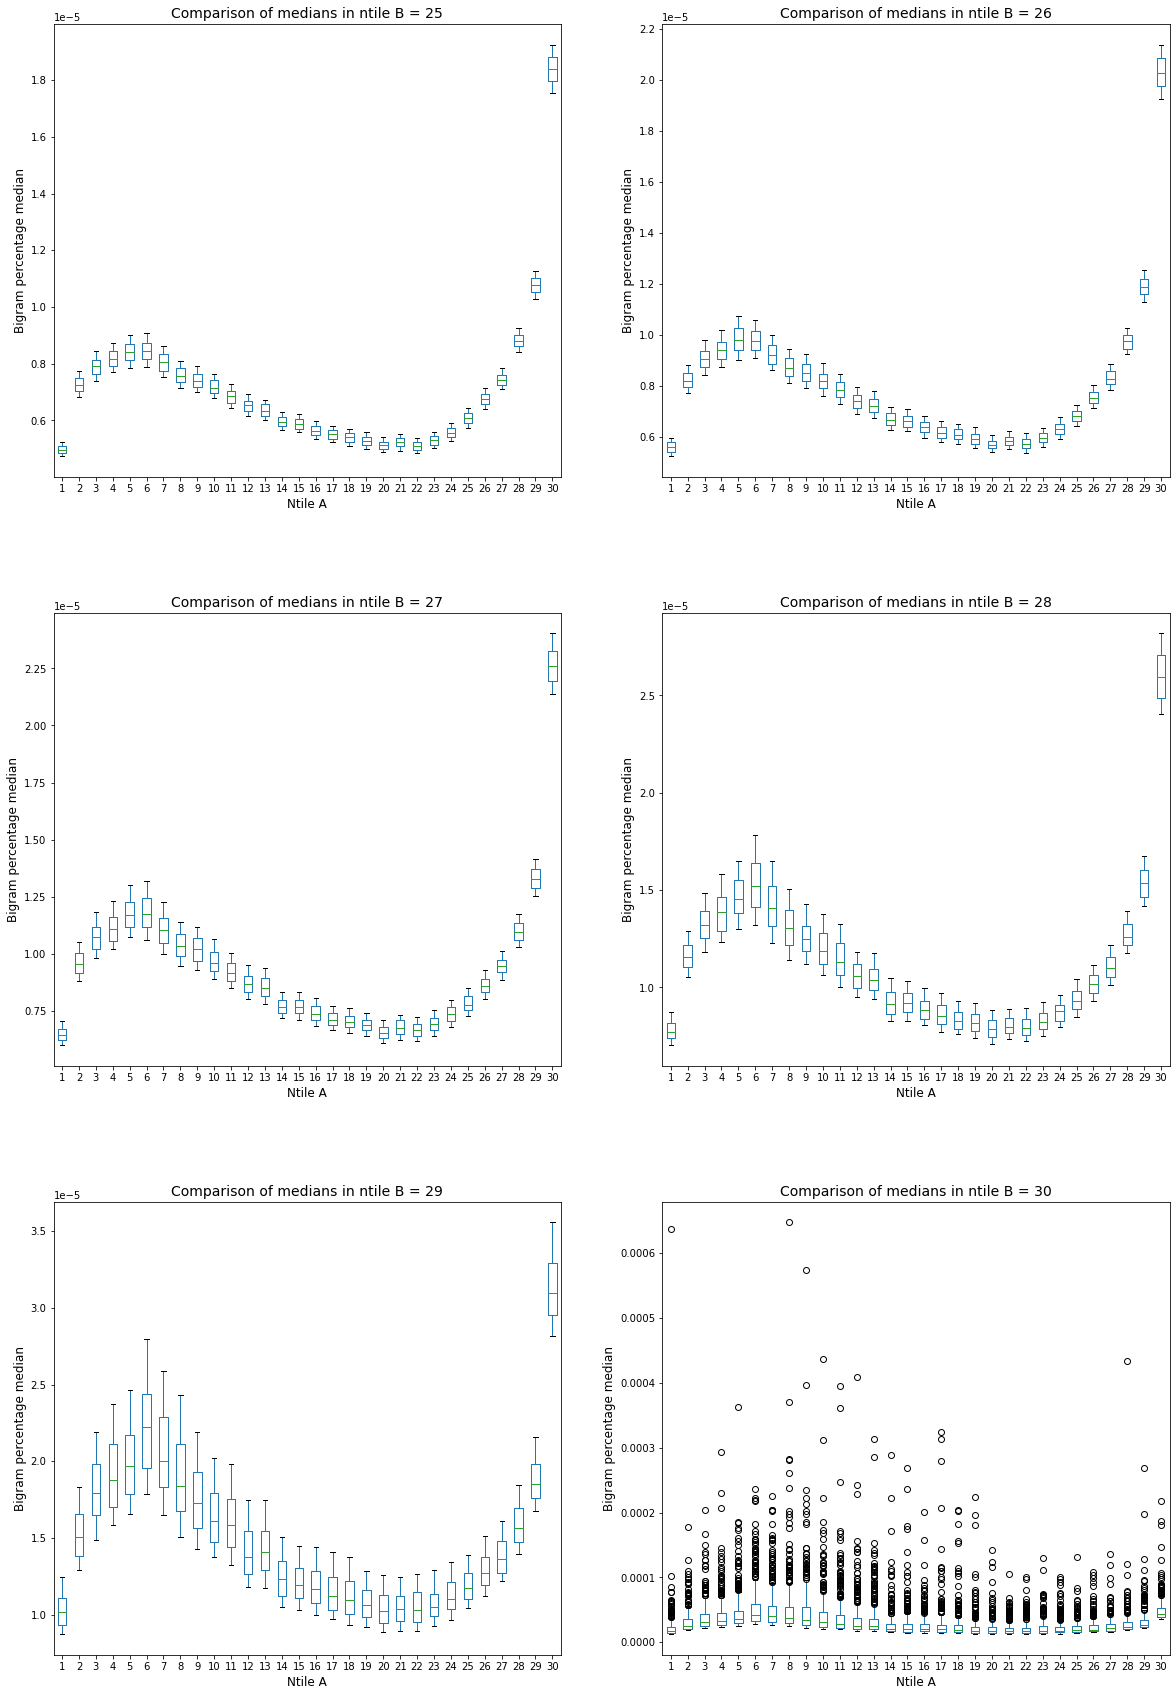

In [35]:
plt.figure(figsize=(20, 30))
for i in range(25, 31):
    df = pd.DataFrame()
    for j in range(1, 31):
        df[j] = pd.DataFrame(medians[(medians.ntileA == j) & (medians.ntileB == i)]
                             ['medianB'][0:400]).reset_index().medianB  
    ax = plt.subplot(3, 2, i-24)
    df.plot.box(ax = ax)
    plt.xlabel('Ntile A', fontsize=12)
    plt.ylabel('Bigram percentage median', fontsize=12)
    plt.title('Comparison of medians in ntile B = ' + str(i), fontsize=14)
    plt.subplots_adjust(hspace=0.3)
plt.savefig('boxplots3',bbox_inches='tight')
plt.show()

### Plot bigrams from the different ntiles

In [19]:
plotpd = df_full_new.toPandas()

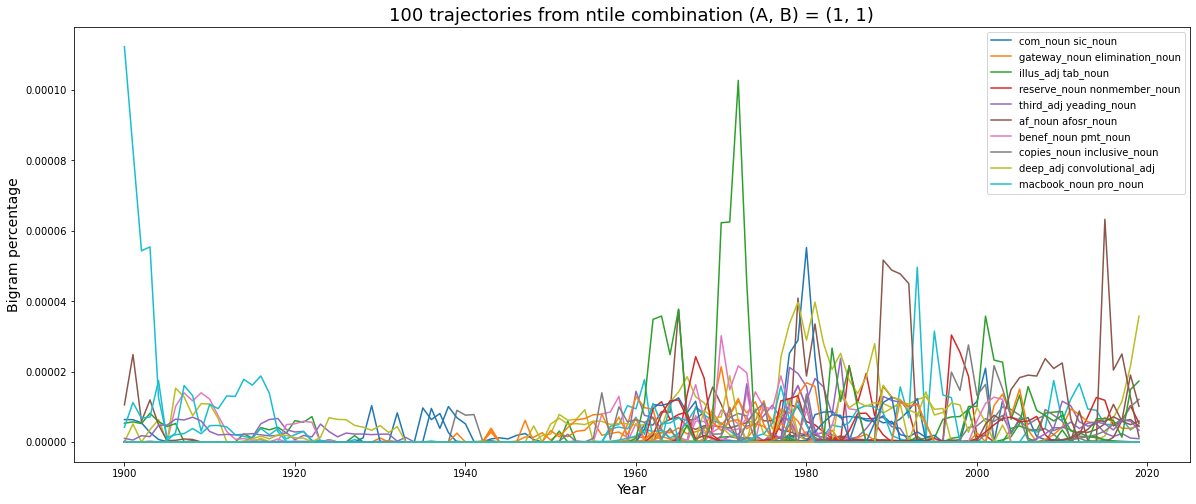

In [38]:
# plot the bigrams for different combinations of medians in the 40 years 1920-1960 and medians in the 40 years between 1980-2019
ntiles = [(1, 1), (1, 15), (1, 25), (1, 29), (15, 1), (15, 15), (15, 25), (15,29), (25, 1), (25, 15), (25, 25), 
          (25, 29), (29, 1), (29, 15), (29, 25), (29, 29)]

for ntile_n in ntiles:
    tmp = plotpd[(plotpd.ntileA == ntile_n[0]) & (plotpd.ntileB == ntile_n[1])]
    plt.figure(figsize=(20,8))
    for bigram in tmp.bigram.unique()[0:100]:
        tmp2 = tmp[(tmp.bigram == bigram)]
        plt.plot(tmp2.year, tmp2.bigram_percent)
    plt.legend(tmp.bigram.unique()[0:10])
    plt.title('100 trajectories from ntile combination (A, B) = ' + str(ntile_n), fontsize=18)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Bigram percentage', fontsize=14)
    plt.savefig('ntile_trajectories_' + str(ntile_n))
    plt.show()

### Save data

In [23]:
df_full_new.write.csv('/data/shared1/cleandata/all_ntiles_with0_newer')

In [24]:
df_full_new.printSchema()

root
 |-- bigram: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- bigram_percent: float (nullable = true)
 |-- medianA: float (nullable = true)
 |-- ntileA: integer (nullable = true)
 |-- medianB: float (nullable = true)
 |-- ntileB: integer (nullable = true)

